In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)

In [17]:
'''
second performance test
'''
%time
import sys
sys.path.append('..')
%matplotlib inline
# you might need this:
#import matplotlib
#matplotlib.use('Agg')

from eden.converter.graph.gspan import gspan_to_eden
from graphlearn.graphlearn import GraphLearnSampler
import itertools
from eden.graph import Vectorizer
import matplotlib.pyplot as plt
import numpy as np

from eden.util import fit_estimator,fit , random_bipartition_iter,estimate
import random
from eden.util import selection_iterator as picker
from sklearn.linear_model import SGDClassifier

vectorizer = Vectorizer( complexity=2 )
#2401 positives and 1936 negatives
NUMPOS=2401
NUMNEG=1936

######################## testing ##############################
from eden.util import iterator_size 
from time import time
def train_estimator_and_evaluate_testsets(pos_original,neg_original,pos_augmented,neg_augmented,pos_test,neg_test):
    # create graph sets...orig augmented and sampled
    pos_orig,pos_orig_ = itertools.tee(pos_original)
    neg_orig,neg_orig_ = itertools.tee(neg_original)
    
    pos_augmented , pos_sampled = itertools.tee(pos_augmented)
    neg_augmented , neg_sampled = itertools.tee(neg_augmented)
    
    pos_augmented = itertools.chain(pos_augmented,pos_orig_)
    neg_augmented = itertools.chain(neg_augmented,neg_orig_)

    predictive_performances=[]
    for desc,pos_train,neg_train in [('original',pos_orig, neg_orig),( 'original+sample',pos_augmented, neg_augmented),('sample',pos_sampled,neg_sampled)]:
        pos_train,pos_train_=itertools.tee(pos_train)
        neg_train,neg_train_=itertools.tee(neg_train)
        pos_size=sum(1 for x in pos_train_)
        neg_size=sum(1 for x in neg_train_)
        start=time()
        print "-"*80
        print 'working on %s'%(desc)
        print 'training set sizes: #pos: %d #neg: %d'%(pos_size, neg_size)
        pos_test,pos_test_=itertools.tee(pos_test)
        neg_test,neg_test_=itertools.tee(neg_test)
        local_estimator = fit( pos_train,neg_train,vectorizer,n_jobs=-1, n_iter_search=1 )
        apr, roc = estimate(pos_test_,neg_test_,local_estimator,vectorizer)
        predictive_performances.append(roc)
        print 'elapsed: %.1f sec'%(time()-start)
    return predictive_performances


def sample(graphs):
    sampler = GraphLearnSampler(radius_list=[0,1,2],thickness_list=[1,2])
    graphs, graphs_ = itertools.tee(graphs)
    sampler.fit(graphs, n_jobs=1, core_interface_pair_remove_threshold=3, interface_remove_threshold=3)
    n_steps=12
    sampling_factor=3 #how many samples per seed
    
    sampling_interval=np.ceil([n_steps/sampling_factor])
    graphs = sampler.sample(graphs_,
                            same_radius=False,
                            same_core_size=True,
                            select_cip_max_tries=200,
                            batch_size=30,
                            n_steps=n_steps,
                            sampling_interval=sampling_interval,
                            n_jobs=-1,
                            annealing_factor=1.2,
                            burnout=0,
                            probabilistic_core_choice=True)
    for graph in list(graphs):
        path_graphs = graph.graph['sampling_info']['graphs_history']
        for path_graph in path_graphs:
            yield path_graph

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 5.01 µs


In [18]:
%time
from time import time
from itertools import tee
# initializing 
graphs_pos= gspan_to_eden('bursi.pos.gspan')
graphs_neg= gspan_to_eden('bursi.neg.gspan')
#take 70% train 30% test
pos_train_global,pos_test_global = random_bipartition_iter(graphs_pos,0.7)
neg_train_global,neg_test_global = random_bipartition_iter(graphs_neg,0.7)

originals=[]
originals_samples=[]
samples=[]

global_start=time()
percentages=[.05, .1,.2,.3,.4,]
for percentage in percentages:
    pos_train_global,pos_train_global_ = tee(pos_train_global)
    neg_train_global,neg_train_global_ = tee(neg_train_global)
    pos_test_global,pos_test_global_ = tee(pos_test_global)
    neg_test_global,neg_test_global_ = tee(neg_test_global)

    # use shuffled list to create test and sample set
    pos,pos_reminder = random_bipartition_iter(pos_train_global_,percentage)
    pos,pos_ = tee(pos)
    neg,neg_reminder = random_bipartition_iter(neg_train_global_,percentage)
    neg,neg_ = tee(neg)
     
    #sample independently from the 2 classes
    sampled_pos = sample(pos)
    sampled_neg = sample(neg)
    
    #evaluate the predictive performance on held out test set
    start=time()
    print "="*80
    print "training percentage:"+str(percentage)
    perf_orig, perf_orig_samp, perf_samp = train_estimator_and_evaluate_testsets(pos_,
                                                                                 neg_,
                                                                                 sampled_pos, 
                                                                                 sampled_neg, 
                                                                                 pos_test_global_,
                                                                                 neg_test_global_)
    originals.append(perf_orig)
    originals_samples.append(perf_orig_samp)
    samples.append(perf_samp)
    print 'Time elapsed for perc: %.2f : %.1f sec'%(percentage,(time()-start))
print 'Total runtime: %.1f sec' % (time()-global_start)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.87 µs
training percentage:0.05
--------------------------------------------------------------------------------
working on original
training set sizes: #pos: 84 #neg: 67
Test set
Instances: 1300 ; Features: 1048577 with an avg of 80 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    recall  f1-score   support

         -1       0.69      0.80      0.74       580
          1       0.81      0.72      0.76       720

avg / total       0.76      0.75      0.75      1300

APR: 0.841
ROC: 0.821
elapsed: 7.0 sec
--------------------------------------------------------------------------------
working on original+sample
training set sizes: #pos: 420 #neg: 335
Test set
Instances: 1300 ; Features: 1048577 with an avg of 80 features per instance
--------------------------------------------------------------------------------
Test Estimate
      

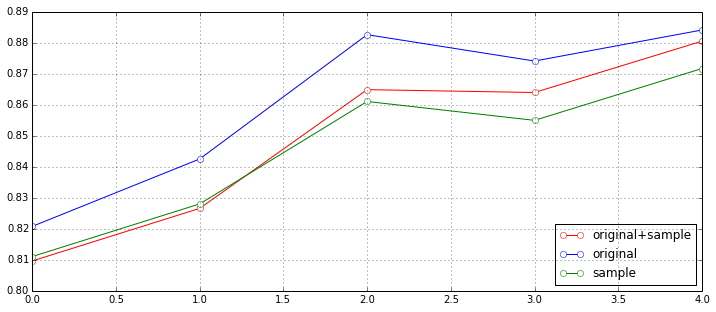

In [19]:
# draw 
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.grid()
plt.plot(originals_samples, color='r', marker='o', markersize=6, markeredgecolor='r', markerfacecolor='w', label='original+sample')
plt.plot(originals, color='b', marker='o', markersize=6, markeredgecolor='b', markerfacecolor='w', label='original')
plt.plot(samples, color='g', marker='o', markersize=6, markeredgecolor='g', markerfacecolor='w', label='sample')
plt.legend(loc='lower right')
plt.savefig('plot_predictive_performance_of_samples.pdf')

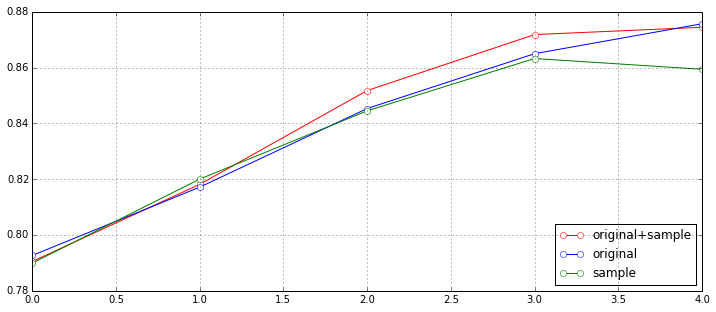

In [16]:
# draw 
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.grid()
plt.plot(originals_samples, color='r', marker='o', markersize=6, markeredgecolor='r', markerfacecolor='w', label='original+sample')
plt.plot(originals, color='b', marker='o', markersize=6, markeredgecolor='b', markerfacecolor='w', label='original')
plt.plot(samples, color='g', marker='o', markersize=6, markeredgecolor='g', markerfacecolor='w', label='sample')
plt.legend(loc='lower right')
plt.savefig('plot_predictive_performance_of_samples.pdf')

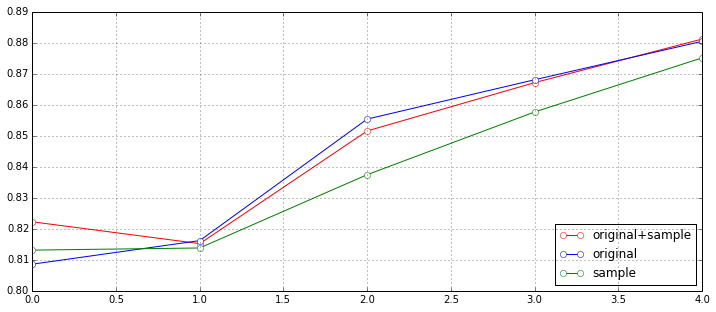

In [13]:
# draw 
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.grid()
plt.plot(originals_samples, color='r', marker='o', markersize=6, markeredgecolor='r', markerfacecolor='w', label='original+sample')
plt.plot(originals, color='b', marker='o', markersize=6, markeredgecolor='b', markerfacecolor='w', label='original')
plt.plot(samples, color='g', marker='o', markersize=6, markeredgecolor='g', markerfacecolor='w', label='sample')
plt.legend(loc='lower right')
plt.savefig('plot_predictive_performance_of_samples.pdf')

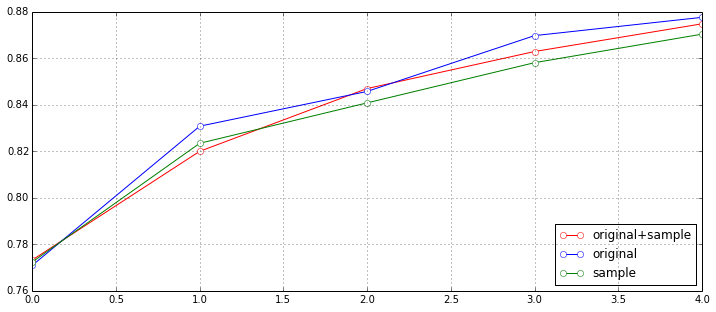

In [10]:
# draw 
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.grid()
plt.plot(originals_samples, color='r', marker='o', markersize=6, markeredgecolor='r', markerfacecolor='w', label='original+sample')
plt.plot(originals, color='b', marker='o', markersize=6, markeredgecolor='b', markerfacecolor='w', label='original')
plt.plot(samples, color='g', marker='o', markersize=6, markeredgecolor='g', markerfacecolor='w', label='sample')
plt.legend(loc='lower right')
plt.savefig('plot_predictive_performance_of_samples.pdf')

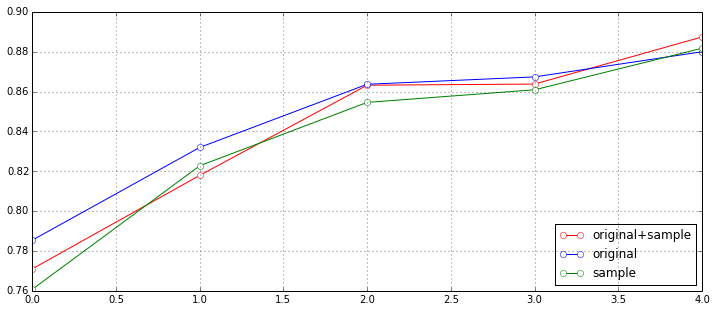

In [7]:
# draw 
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.grid()
plt.plot(originals_samples, color='r', marker='o', markersize=6, markeredgecolor='r', markerfacecolor='w', label='original+sample')
plt.plot(originals, color='b', marker='o', markersize=6, markeredgecolor='b', markerfacecolor='w', label='original')
plt.plot(samples, color='g', marker='o', markersize=6, markeredgecolor='g', markerfacecolor='w', label='sample')
plt.legend(loc='lower right')
plt.savefig('plot_predictive_performance_of_samples.pdf')

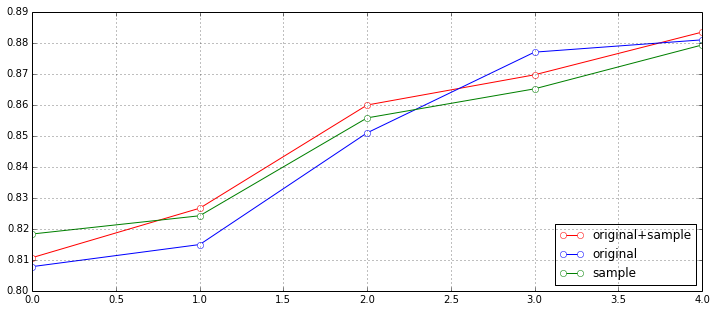

In [5]:
# draw 
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.grid()
plt.plot(originals_samples, color='r', marker='o', markersize=6, markeredgecolor='r', markerfacecolor='w', label='original+sample')
plt.plot(originals, color='b', marker='o', markersize=6, markeredgecolor='b', markerfacecolor='w', label='original')
plt.plot(samples, color='g', marker='o', markersize=6, markeredgecolor='g', markerfacecolor='w', label='sample')
plt.legend(loc='lower right')
plt.savefig('plot_predictive_performance_of_samples.pdf')